<center><h1>Методы Монте-Карло и машинное обучение</h1></center>

In [ ]:
!python -V # Версия Python

Python 3.12.8


In [ ]:
# Подавление предупреждений
import warnings
for warn in [UserWarning, FutureWarning]: warnings.filterwarnings("ignore", category = warn)

### Импорт необходимых библиотек
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import polars as pl
import pandas as pd
import sklearn
import scipy
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import jupyterlab as jlab
import ipywidgets
import random

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.datasets import fetch_20newsgroups
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
### Версии необходимых библиотек
packages = [
    "Torch", "NumPy", "Polars", "Pandas", "Seaborn", "Matplotlib", "Scipy", "Scikit-learn", "Ipywidgets", "JupyterLab"
]

package_objects = [
    torch, np, pl, pd, sns, mpl, scipy, sklearn, ipywidgets, jlab
]

versions = list(map(lambda obj: obj.__version__, package_objects))

columns_order = ["№", "Библиотека", "Версия"]
df_pkgs = (
    pl.DataFrame({
        columns_order[1]: packages,
        columns_order[2]: versions
    })
    .with_columns(pl.arange(1, pl.lit(len(packages)) + 1).alias(columns_order[0]))
    .select(columns_order)
)

display(df_pkgs)

path2reqs = "."
reqs_name = "requirements.txt"

def get_packages_and_versions():
    """Генерация строк с библиотеками и их версиями в формате: библиотека==версия"""

    for package, version in zip(packages, versions):
        yield f"{package.lower()}=={version}\n"

with open(os.path.join(path2reqs, reqs_name), "w", encoding = "utf-8") as f:
    f.writelines(get_packages_and_versions())

№,Библиотека,Версия
i64,str,str
1,"""Torch""","""2.2.2"""
2,"""NumPy""","""1.26.4"""
3,"""Polars""","""1.19.0"""
4,"""Pandas""","""2.2.3"""
5,"""Seaborn""","""0.13.2"""
6,"""Matplotlib""","""3.10.0"""
7,"""Scipy""","""1.15.1"""
8,"""Scikit-learn""","""1.6.1"""
9,"""Ipywidgets""","""8.1.5"""


# Лекция 4

5. **Монте-Карло в задачах обработки естественного языка (NLP).**
    - Применение методов Монте-Карло для оценки неопределенности в задачах NLP.
    - Особое внимание уделяется задачам классификации текстов и распознаванию именованных сущностей (NER).

## Зачем оценивать неопределенность в NLP?

### Проблемы точечных предсказаний

Современные NLP-модели (например, **BERT, SBERT, GPT**) выдают **детерминированные предсказания**:
- **Для классификации** - одно число: вероятность принадлежности к классу
- **Для генерации текста или NER** - наиболее вероятную последовательность токенов

#### Ограничения таких предсказаний

1. **Отсутствие информации об уверенности**  
    - Вероятность, выдаваемая моделью, **не отражает уверенность**
    - Например, если модель предсказывает `toxic: 0.51`, это может означать
        - **Высокую алеаторную неопределенность** (шум в данных, текст неоднозначен)
        - **Высокую эпистемическую неопределенность** (модель недостаточно обучена на подобных примерах)
2. **Риск переобучения**  
    - Модель может быть **излишне уверена в ошибочных предсказаниях**
    - На данных, **отличных от обучающих**, вероятности могут быть далеки от реальности

## Два основных типа неопределенности в NLP

### Алеаторная неопределенность (Aleatoric Uncertainty)

#### Что это такое?

`Алеаторная неопределенность` - это **неизбежный шум в данных**, который **не может быть устранен даже при увеличении количества примеров**. Она обусловлена **внутренней неоднозначностью данных**, а не недостатками модели

#### Примеры

1. **Двусмысленность в тексте**  
    - `Он отличный игрок` - **позитивный тон** (однозначное предсказание)
    - `Он отличный игрок, но у него ужасная техника` - **двусмысленность** (может быть нейтральным или негативным)
2. **Шум в аннотациях**  
   - Один аннотатор считает, что текст нейтральный
   - Другой аннотатор видит в нем скрытый негатив
   - Итог: **размытые вероятности классов**

#### Как формализуется алеаторная неопределенность?

Она определяется через **энтропию предсказаний** модели

$$
H(y | x) = - \sum_{c} p(y = c | x) \log p(y = c | x)
$$

где:
- $p(y = c | x)$ - вероятность класса $c$ для примера $x$
- Чем выше $H(y | x)$, тем **сильнее размыто распределение** вероятностей - **более высокая неопределенность**

#### Интерпретация

- **Низкая энтропия ($H(y | x) \approx 0$)**
    - **Модель уверена** в своем предсказании
    - Например:
        ```plaintext
        Текст: "Этот телефон отлично работает!"
        Предсказания: [positive: 0.98, neutral: 0.01, negative: 0.01]
        Энтропия: низкая
        ```

- **Высокая энтропия ($H(y | x) \gg 0$)**
    - **Модель не уверена** (распределение вероятностей размыто)
    - Например:
        ```plaintext
        Текст: "Этот телефон хороший, но батарея ужасная."
        Предсказания: [positive: 0.4, neutral: 0.3, negative: 0.3]
        Энтропия: высокая
        ```

#### Разбор на практике

Предположим, у нас есть **модель классификации тональности текста**

##### **Шаг 1. Предсказание вероятностей**

Пусть модель предсказывает вероятности классов (`positive`, `neutral`, `negative`)

| Текст                                      | Positive | Neutral | Negative |
|--------------------------------------------|----------|---------|----------|
| "Я в восторге от этого фильма!"            | 0.95     | 0.04    | 0.01     |
| "Фильм неплохой, но концовка подкачала."   | 0.40     | 0.30    | 0.30     |

##### **Шаг 2. Вычисление энтропии**

Формула

$$
H(y | x) = - \sum_{c} p(y = c | x) \log p(y = c | x)
$$

Для первого текста:

$$
H = - (0.95 \log 0.95 + 0.04 \log 0.04 + 0.01 \log 0.01)
$$

$$
\approx - (0.95 \times (-0.02) + 0.04 \times (-1.40) + 0.01 \times (-2.00)) = 0.12
$$

**Низкая энтропия -> модель уверена**

Для второго текста:

$$
H = - (0.40 \log 0.40 + 0.30 \log 0.30 + 0.30 \log 0.30)
$$

$$
\approx - (0.40 \times (-0.40) + 0.30 \times (-0.52) + 0.30 \times (-0.52)) = 1.08
$$

**Высокая энтропия -> модель не уверена**

#### Важность для NLP-моделей

1. **Фильтрация ненадежных предсказаний**  
    - Если энтропия высока, можно пометить пример как **требующий ручной проверки**
2. **Гибридные модели с активным обучением**  
    - Можно отправлять примеры с **высокой энтропией** на доразметку и переобучать модель
3. **Генерация интерпретируемых ответов**  
    - В диалоговых системах, если модель **не уверена**, можно добавлять дискурсивные маркеры
        - `Это определенно правильно!`
        - `Я не совсем уверен, но вероятно, это так ...`

#### Итог

- Алеаторная неопределенность **не устраняется** увеличением данных, так как она связана с шумом в самих данных
- Ее можно **измерять через энтропию предсказаний**
- В NLP-решениях она помогает **улучшить интерпретируемость и качество предсказаний**

### Эпистемическая неопределенность (Epistemic Uncertainty)

#### Что это такое?

Эпистемическая неопределенность - это **неуверенность модели**, которая возникает из-за **нехватки данных** или **неопределенности параметров** модели. Она **уменьшается при увеличении данных**, так как с добавлением новых примеров модель может уточнить свои параметры и улучшить предсказания

#### Примеры

1. **Недостаток данных.** Модель, обученная на ограниченном наборе данных, может неадекватно интерпретировать новые, еще не встречавшиеся примеры
2. **Неопределенность параметров модели.** Разные значения параметров модели могут приводить к различным предсказаниям, особенно когда параметры недостаточно точно оценены

#### Как формализуется эпистемическая неопределенность?

Она определяется через **апостериорное распределение параметров модели**

$$
p(y | x, D) = \int p(y | x, \theta) p(\theta | D) d\theta
$$

где:
- $p(y | x, \theta)$ - предсказание модели с параметрами $\theta$ для входа $x$
- $p(\theta | D)$ - апостериорное распределение параметров модели, которое описывает **неопределенность** в параметрах после обучения на данных $D$

#### Интерпретация

- $p(y | x, D)$ — это **ожидаемое предсказание** модели с учетом всех возможных параметров $\theta$, которые могут быть найдены на основе обучающих данных
- $p(\theta | D)$ - описывает **неопределенность** в параметрах модели после наблюдения обучающих данных

#### Как использовать методы Монте-Карло для оценки эпистемической неопределенности?

Аналитически оценить интеграл, описывающий эпистемическую неопределенность, невозможно. Однако можно использовать **Методы Монте-Карло** для **аппроксимации** этого интеграла

##### Байесовская точка зрения

Для вычисления $p(y | x, D)$ можно использовать байесовский подход

$$
p(y | x, D) = \int p(y | x, \theta) p(\theta | D) d\theta
$$

где:
- Происходит **интеграция** по всем возможным параметрам $\theta$, взвешивая их по вероятности $p(\theta | D)$

##### Использование Монте-Карло

Чтобы аппроксимировать этот интеграл, можно использовать методы Монте-Карло, такие как **Марковские цепи Монте-Карло (MCMC)** или **методы с выбором случайных образцов**

1. **Сэмплирование параметров $\theta$**
    - Использование метода, например, **MCMC**, чтобы сэмплировать значения параметров $\theta$ из апостериорного распределения $p(\theta | D)$
2. **Прогнозирование с использованием сэмплированных параметров**
    - Для каждого сэмплированного значения $\theta$ вычисляется предсказание $p(y | x, \theta)$
3. **Вычисление среднего и дисперсии предсказаний**
    - Для оценки эпистемической неопределенности вычисляется **среднее** и **дисперсия** предсказаний для всех сэмплированных параметров $\theta$

#### Важность для NLP-моделей

1. **Уменьшение неопределенности**
    - Эпистемическая неопределенность может быть **снижена** с помощью **дополнительных данных** или **обучения на различных подмножествах данных**. Например, можно улучшить классификацию текстов с помощью **дополнительных аннотированных данных**
2. **Активное обучение**
    - В случае, когда данные ограничены, можно использовать **активное обучение**, где модель запрашивает **дополнительные данные**, особенно для тех примеров, где она наиболее неуверенна (например, с высокой эпистемической неопределенностью)
3. **Использование SBERT для оценки эпистемической неопределенности**
    - **SBERT** (Sentence-BERT) может быть использован для извлечения **семантических представлений** предложений. Для оценки эпистемической неопределенности можно комбинировать SBERT с вероятностными моделями, такими как **Bayesian Neural Networks** или **Monte Carlo Dropout**, чтобы получать предсказания с учетом неопределенности

#### Итог

- Эпистемическая неопределенность **связана с недостатком данных** или **неопределенностью параметров модели**
- Ее можно уменьшить с помощью **дополнительных данных** или **обучения на разных подмножествах**
- Для ее оценки можно использовать **Методы Монте-Карло** и **Модели Байесовского вывода**
- SBERT и другие модели могут помочь в **вычислениях и обработке** текстов с учетом неопределенности

## Методы Монте-Карло в NLP

### Монте-Карло Dropout (MC Dropout)

В стандартных нейросетях дропаут отключается на инференсе (во время процесса работы обученной нейросети). Но если оставить его **включенным**, можно получить множество предсказаний с разными **масками отключенных нейронов**

$$
\hat{y}^{(t)} = f_{\theta^{(t)}}(x), \quad t = 1, \dots, T
$$

**Что это дает?**
- **Эпистемическую неопределенность**: дисперсия предсказаний
- **Более надежную оценку вероятностей**

Оценки:
- **Среднее предсказаний**
    $$
    \mathbb{E}[\hat{y}] = \frac{1}{T} \sum_{t=1}^{T} \hat{y}^{(t)}
    $$
- **Дисперсия предсказаний**
    $$
    \text{Var}[\hat{y}] = \frac{1}{T} \sum_{t=1}^{T} (\hat{y}^{(t)} - \mathbb{E}[\hat{y}])^2
    $$

#### Применение в NLP

- Оценка неопределенности в **классификации текстов**
- Выявление ненадежных предсказаний в **NER**

### Байесовские нейросети (BNN)

Вместо фиксированных параметров $\theta$ рассматривается **распределение** параметров

$$
p(\theta | D)
$$

Тогда предсказание записывается как интеграл

$$
p(y | x, D) = \int p(y | x, \theta) p(\theta | D) d\theta
$$

Но аналитически посчитать **невозможно** -> используется **Методы Монте-Карло**:
- **Metropolis-Hastings** - симуляция случайного процесса

**Применение в NLP.** Используется в **SBERT**, где оценки неопределенности помогают в **поиске устойчивых эмбеддингов текстов**

### Гибридные методы: Deep Ensembles + MC Dropout

Обучается несколько **независимых** моделей и усредняются их предсказания

$$
p(y | x) \approx \frac{1}{N} \sum_{i=1}^{N} p(y | x, \theta_i)
$$

**Преимущества**
- Уменьшается влияние отдельных случайных факторов
- Повышается устойчивость к аномалиям

**Применение в NLP.** Используется в **SBERT**, где объединение нескольких эмбеддингов помогает уменьшить неопределенность в **семантическом поиске**

## Применение методов Монте-Карло в NLP-задачах

### Классификация текстов

- MC Dropout помогает оценить доверие модели
- Если **дисперсия предсказаний высока**, возможно, текст **отличается от обучающих данных**

### Распознавание именованных сущностей (NER)

- Байесовские модели улучшают предсказания для **неоднозначных именованных сущностей**
- Дисперсия предсказаний может сигнализировать, когда NER-модель **не уверена в разметке**

### Семантический поиск (SBERT)

- **SBERT** использует эмбеддинги для поиска **похожих текстов**
- Монте-Карло позволяет **оценивать неопределенность эмбеддингов**, улучшая их интерпретируемость

## Выводы

Методы Монте-Карло дают **важную информацию об уверенности модели**, что особенно полезно в **NLP-задачах**
- В классификации текстов помогает находить **ненадежные предсказания**
- В NER снижает ошибки на **неоднозначных именованных сущностях**
- В SBERT улучшает **интерпретируемость эмбеддингов**

**Ключевая идея.** Использование Монте-Карло позволяет моделям не только предсказывать, **но и понимать, насколько они уверены в своем предсказании**

## Примеры методов Монте-Карло в NLP

### Простой пример: MC Dropout для классификации текста

Предположим, у нас есть текстовый классификатор, который классифицирует текст как `позитивный` или `негативный`. Включаем дропаут на этапе инференса и генерируем несколько предсказаний, получая распределение вероятностей для разных масок нейронов

#### Генерация предсказаний

Текст:
> "Это замечательный фильм!"

Предсказания (с 5 различными масками нейронов)

| Предсказание | Позитивный | Негативный |
|--------------|------------|------------|
| 1            | 0.92       | 0.08       |
| 2            | 0.90       | 0.10       |
| 3            | 0.91       | 0.09       |
| 4            | 0.89       | 0.11       |
| 5            | 0.93       | 0.07       |

#### Среднее и дисперсия предсказаний

Среднее предсказание для класса `Позитивный`

$$
\mathbb{E}[\hat{y}] = \frac{1}{5} \sum_{t=1}^{5} \hat{y}^{(t)} = \frac{0.92 + 0.90 + 0.91 + 0.89 + 0.93}{5} = 0.91
$$

Дисперсия

$$
\text{Var}[\hat{y}] = \frac{1}{5} \sum_{t=1}^{5} (\hat{y}^{(t)} - \mathbb{E}[\hat{y}])^2 = 0.00042
$$

### Пример: Байесовская нейросеть для NER

Предположим, используется модель для распознавания именованных сущностей (NER). Для задачи `Распознавание имен` применяется Байесовская нейросеть, в которой параметры модели распределены, а не фиксированы. Оценивается неопределенность предсказания для сложной сущности, как например, название компании.

#### Пример текста и сущности

Текст:  
> "Компания Яндекс объявила о новом продукте."

Предсказание с использованием Байесовской нейросети:  
- "Яндекс" -> компания

#### 2.2. Байесовское распределение параметров

Используются методы Монте-Карло для аппроксимации апостериорного распределения параметров модели $p(\theta | D)$. Например, после нескольких выборок (например, 10) из распределения параметров получаются различные предсказания для сущности:

| Выборка | Сущность     | Уверенность (вероятность) |
|---------|--------------|---------------------------|
| 1       | Яндекс       | 0.85                      |
| 2       | Яндекс       | 0.88                      |
| 3       | Яндекс       | 0.87                      |
| 4       | Сбер         | 0.12                      |
| 5       | Озон         | 0.05                      |

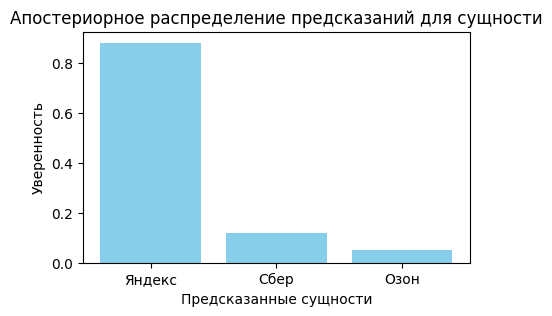

In [ ]:
# Пример данных апостериорного распределения
samples = ["Яндекс", "Яндекс", "Яндекс", "Сбер", "Озон"]
confidence = [0.85, 0.88, 0.87, 0.12, 0.05]

plt.figure(figsize = (5, 3))
plt.bar(samples, confidence, color = "skyblue")
plt.xlabel("Предсказанные сущности")
plt.ylabel("Уверенность")
plt.title("Апостериорное распределение предсказаний для сущности")
plt.show()

# Семинар 4

**Монте-Карло для задач обработки естественного языка (NLP).**
- Практические задания по оценке вероятностей и улучшению качества текстовых моделей с использованием методов Монте-Карло.

### Цель

Оценить неопределенность предсказаний модели классификации текстов с помощью метода **MC Dropout** и сравнить точность модели с и без использования этого метода

Эпоха 1/50, Потери: 2.9961
Эпоха 2/50, Потери: 2.9702
Эпоха 3/50, Потери: 2.8407
Эпоха 4/50, Потери: 2.5552
Эпоха 5/50, Потери: 2.4590
Эпоха 6/50, Потери: 2.3685
Эпоха 7/50, Потери: 1.9432
Эпоха 8/50, Потери: 1.8592
Эпоха 9/50, Потери: 1.7455
Эпоха 10/50, Потери: 1.4897
Эпоха 11/50, Потери: 1.3549
Эпоха 12/50, Потери: 1.3037
Эпоха 13/50, Потери: 1.1596
Эпоха 14/50, Потери: 1.0741
Эпоха 15/50, Потери: 1.0232
Эпоха 16/50, Потери: 0.9733
Эпоха 17/50, Потери: 0.8931
Эпоха 18/50, Потери: 0.8415
Эпоха 19/50, Потери: 0.8004
Эпоха 20/50, Потери: 0.7582
Эпоха 21/50, Потери: 0.7028
Эпоха 22/50, Потери: 0.6505
Эпоха 23/50, Потери: 0.6300
Эпоха 24/50, Потери: 0.6043
Эпоха 25/50, Потери: 0.5617
Эпоха 26/50, Потери: 0.5292
Эпоха 27/50, Потери: 0.4997
Эпоха 28/50, Потери: 0.4788
Эпоха 29/50, Потери: 0.4515
Эпоха 30/50, Потери: 0.4215
Эпоха 31/50, Потери: 0.3965
Эпоха 32/50, Потери: 0.3740
Эпоха 33/50, Потери: 0.3510
Эпоха 34/50, Потери: 0.3327
Эпоха 35/50, Потери: 0.3089
Эпоха 36/50, Потери: 0.2869
Э

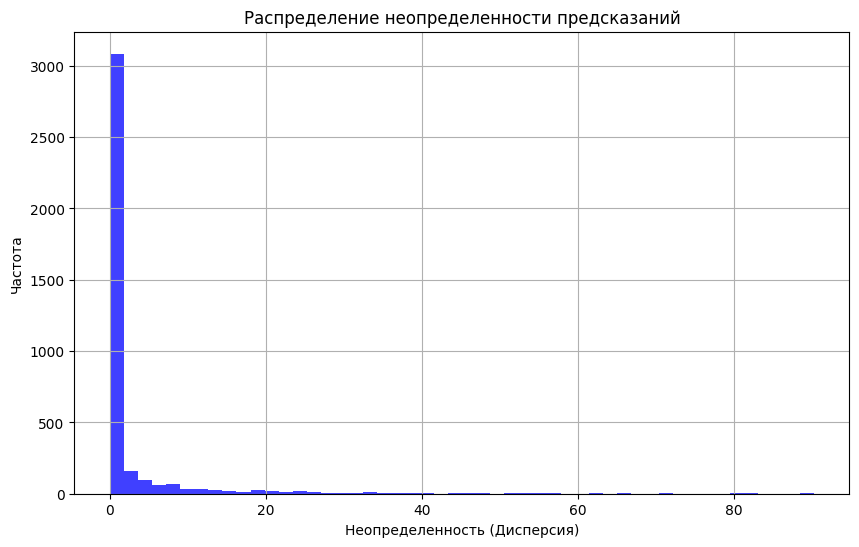

In [ ]:
# Загрузка данных
newsgroups = fetch_20newsgroups(subset = "all")
X = newsgroups.data
y = newsgroups.target

# Преобразование текста в числовые данные
vectorizer = TfidfVectorizer(max_features = 1000)
X_tfidf = vectorizer.fit_transform(X).toarray()

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size = 0.2, random_state = 42)

# Преобразование в тензоры
X_train_tensor = torch.tensor(X_train, dtype = torch.float32)
y_train_tensor = torch.tensor(y_train, dtype = torch.long)
X_test_tensor = torch.tensor(X_test, dtype = torch.float32)
y_test_tensor = torch.tensor(y_test, dtype = torch.long)

# Создание модели
class EnhancedNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(EnhancedNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(p = 0.15)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# Параметры модели
input_size = X_train.shape[1] # Количество признаков
hidden_size = 512
output_size = len(np.unique(y_train)) # Количество классов

# Создание модели и оптимизатора
model = EnhancedNN(input_size, hidden_size, output_size)
optimizer = optim.Adam(model.parameters(), lr = 0.01)

# Балансировка классов
class_counts = np.bincount(y_train)
class_weights = 1. / torch.tensor(class_counts, dtype = torch.float32)
criterion = nn.CrossEntropyLoss(weight = class_weights) # Взвешенная функция потерь

# Функция обучения
def train_model(model, X_train_tensor, y_train_tensor, optimizer, criterion, epochs = 50):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        print(f"Эпоха {epoch+1}/{epochs}, Потери: {loss.item():.4f}")

# Обучение модели
train_model(model, X_train_tensor, y_train_tensor, optimizer, criterion)

# Оценка точности без MC Dropout
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs, 1) # Получение предсказаний
    correct = (predicted.numpy() == y_test).sum() # Сравнение с реальными метками
    accuracy_without_mc = correct / len(y_test) * 100

# Оценка точности с MC Dropout
def mc_dropout(model, X_test_tensor, T = 500): # Количество прогонов
    model.train() # Включение режима обучения для Dropout
    all_predictions = []
    with torch.no_grad():
        for _ in range(T):
            outputs = model(X_test_tensor)
            _, predicted = torch.max(outputs, 1)
            all_predictions.append(predicted.numpy())

    all_predictions = np.array(all_predictions)
    return all_predictions

# Получение неопределенности с MC Dropout
T = 500 # Количество прогонов
all_predictions = mc_dropout(model, X_test_tensor, T)

# Рассчитывание точности на основе голосования
final_predictions = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis = 0, arr = all_predictions)
correct_with_mc = (final_predictions == y_test).sum()
accuracy_with_mc = correct_with_mc / len(y_test) * 100

# Вывод результатов
print(f"Точность с MC Dropout: {accuracy_with_mc:.2f}%")
print(f"Точность без MC Dropout: {accuracy_without_mc:.2f}%")

# Визуализация неопределенности
uncertainties = np.var(all_predictions, axis = 0) # Неопределенность - это дисперсия

# Визуализация распределения неопределенности
plt.figure(figsize = (10, 6))
plt.hist(uncertainties, bins = 50, alpha = 0.75, color = "blue")
plt.title("Распределение неопределенности предсказаний")
plt.xlabel("Неопределенность (Дисперсия)")
plt.ylabel("Частота")
plt.grid(True)
plt.show()

### Домашнее задание

#### Оценить неопределенности в задачах классификации текстов с помощью методов Монте-Карло

#### Цель

Реализовать модель для классификации текстов с применением **MC Dropout** для оценки неопределенности.

#### Шаги

1. Использовать любую знакомую **нейронную сеть** для классификации текстов с дополнительным(и) слоем(ями) **Dropout**
2. Обучить модели на корпусе для классификации текстов, выбрать любой (в зависимости от предпочтений и доступных вычислительных ресурсов)
3. Реализовать **MC Dropout**
    - Сделать несколько прогонов (например, от 500 до 5000 с шагом 500) с включенным dropout, чтобы оценить неопределенность прогноза
    - Для каждого прогноза модели, сохранить несколько вариантов предсказаний и вычислить их дисперсию для оценки неопределенности
4. Сравнить результаты точности модели
    - **С MC Dropout**
    - **Без MC Dropout** (стандартный режим без dropout)
5. Рассчитать **апостериорные распределения** для предсказаний модели (например, для каждого класса)
    - Проанализировать распределение вероятностей для каждого класса после выполнения нескольких прогонов с включенным dropout
6. Провести **анализ чувствительности**
    - Как изменения в параметрах модели (например, увеличение/уменьшение dropout) влияют на точность и неопределенность модели
    - Как различные значения dropout влияют на дисперсию и точность модели. Попробовать несколько различных значений для гиперпараметра dropout (например, 0.2, 0.4, 0.6) и исследовать их влияние на результаты

#### Требования к выполнению

- Все результаты должны быть визуализированы с использованием графиков (например, с помощью библиотеки `matplotlib` или `seaborn`)
- Оценить не только точность, но и неопределенность (дисперсию) предсказаний
- Для оценки неопределенности использовать **MC Dropout** и провести подробный анализ результатов
- Провести анализ чувствительности и сравнить результаты для разных значений dropout

In [8]:
!pip install torchtext==0.6.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 5.0 MB/s eta 0:00:00
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.18.0
    Uninstalling torchtext-0.18.0:
      Successfully uninstalled torchtext-0.18.0


In [16]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from datasets import load_dataset

In [17]:
categories = ['alt.atheism', 'comp.graphics', 'sci.med', 'rec.sport.baseball', 'talk.politics.guns']
newsgroups_train = fetch_20newsgroups(
    subset='train',
    categories=categories,
    remove=('headers','footers','quotes')
)
newsgroups_test = fetch_20newsgroups(
    subset='test',
    categories=categories,
    remove=('headers','footers','quotes')
)

X_train_texts = newsgroups_train.data
y_train_labels = newsgroups_train.target
X_test_texts = newsgroups_test.data
y_test_labels = newsgroups_test.target

In [18]:
vectorizer = TfidfVectorizer(max_features=1000)
X_train_tfidf = vectorizer.fit_transform(X_train_texts).toarray()
X_test_tfidf  = vectorizer.transform(X_test_texts).toarray()

X_train = torch.tensor(X_train_tfidf, dtype=torch.float32)
y_train = torch.tensor(y_train_labels, dtype=torch.long)
X_test  = torch.tensor(X_test_tfidf, dtype=torch.float32)
y_test  = torch.tensor(y_test_labels, dtype=torch.long)
dropout_rates = [0.2, 0.4, 0.6]

In [19]:
results = {}
uncertainties = {}
posterior_probs = {}

class TextClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_rate):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)

In [21]:
T = 500
for dr in dropout_rates:
    model = TextClassifier(
        input_size=X_train.shape[1], hidden_size=512,
        output_size=len(torch.unique(y_train)), dropout_rate=dr
    )
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()
    for epoch in range(10):
        model.train()
        optimizer.zero_grad()
        logits = model(X_train)
        loss = criterion(logits, y_train)
        loss.backward()
        optimizer.step()
    model.eval()
    with torch.no_grad():
        logits = model(X_test)
        acc_no_mc = (logits.argmax(dim=1) == y_test).float().mean().item()
    mc_preds = []
    mc_probs = []
    model.train()
    with torch.no_grad():
        for _ in range(T):
            logits = model(X_test)
            probs = torch.softmax(logits, dim=1).cpu().numpy()
            pred = probs.argmax(axis=1)
            mc_preds.append(pred)
            mc_probs.append(probs)
    mc_preds = np.array(mc_preds)
    mc_probs = np.array(mc_probs)
    final_pred = np.apply_along_axis(lambda x: np.bincount(x).argmax(), 0, mc_preds)
    acc_mc = (final_pred == y_test.numpy()).mean()
    var_preds = np.var(mc_preds, axis=0)
    prob_dists = {c: mc_probs[:, :, c].ravel() for c in range(mc_probs.shape[2])}
    results[dr] = (acc_no_mc, acc_mc)
    uncertainties[dr] = var_preds
    posterior_probs[dr] = prob_dists

for dr in dropout_rates:
    no_mc, with_mc = results[dr]
    print(f"dropout={dr}: acc_without_mc={no_mc:.4f}, acc_with_mc={with_mc:.4f}")

dropout=0.2: acc_without_mc=0.7630, acc_with_mc=0.7625
dropout=0.4: acc_without_mc=0.7587, acc_with_mc=0.7582
dropout=0.6: acc_without_mc=0.7598, acc_with_mc=0.7587


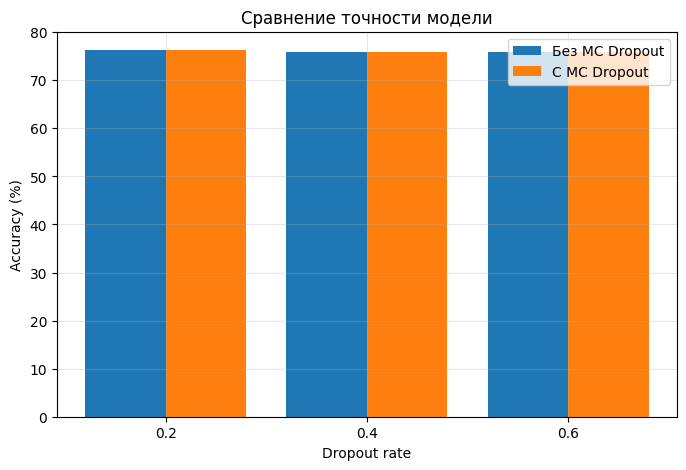

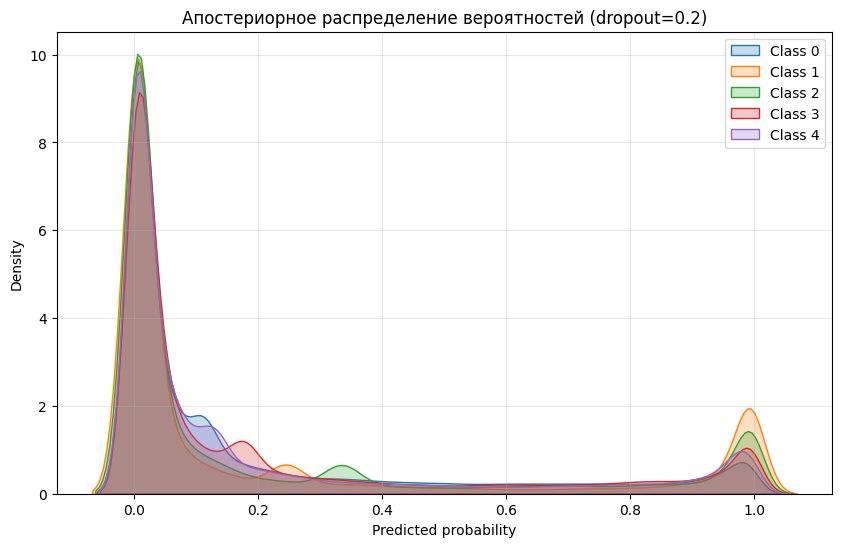

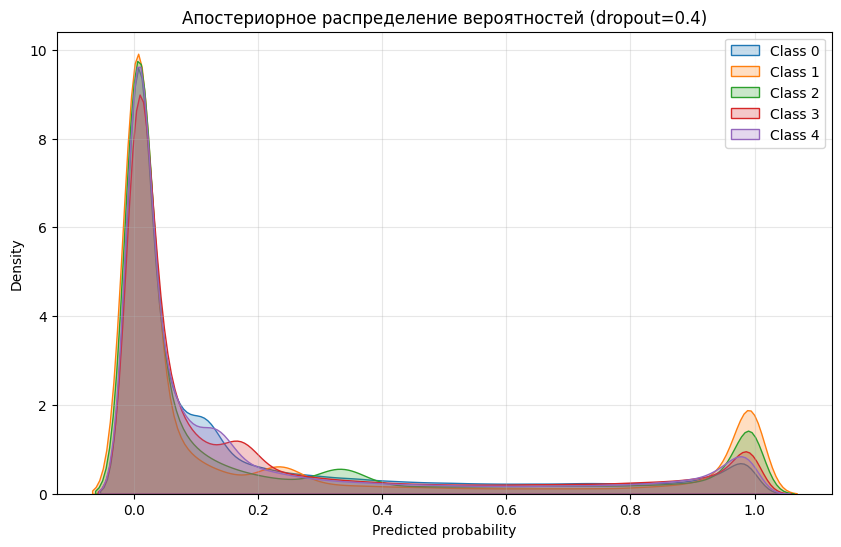

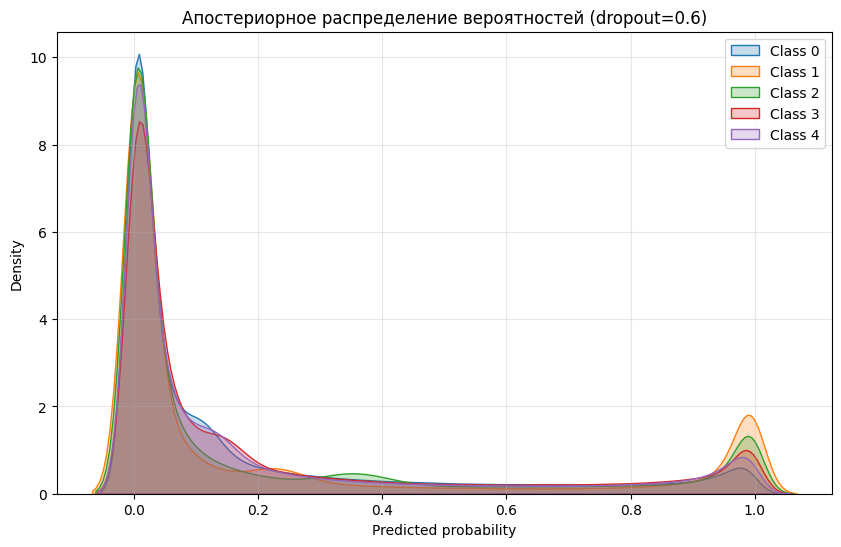

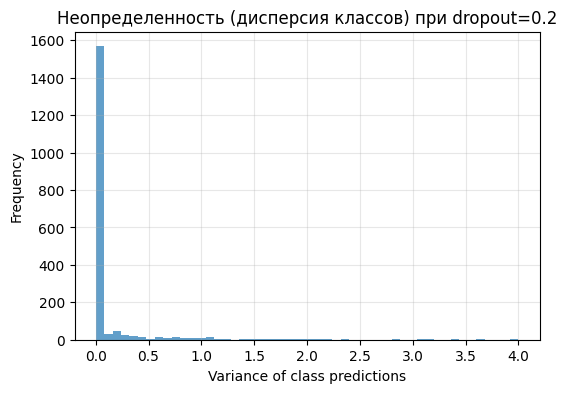

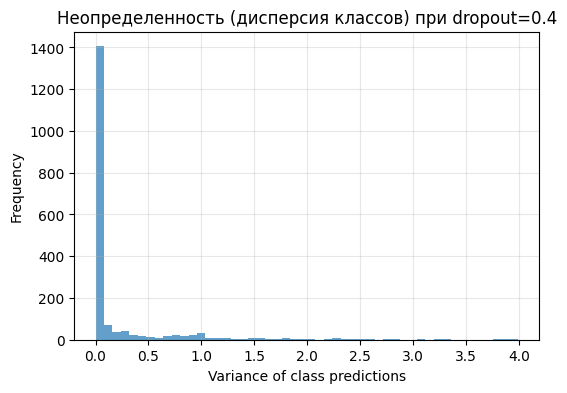

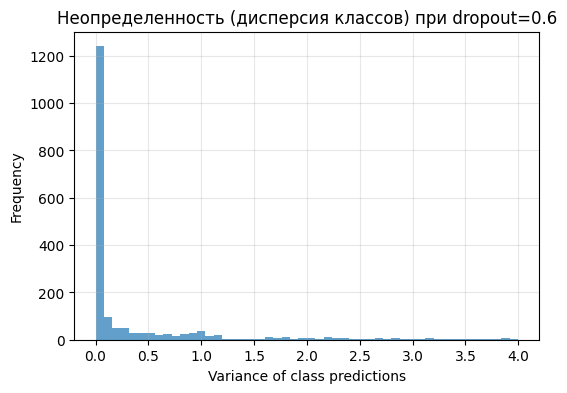

In [22]:
labels = [str(dr) for dr in dropout_rates]
accs = [results[dr][0]*100 for dr in dropout_rates]
mc_accs = [results[dr][1]*100 for dr in dropout_rates]
x = np.arange(len(labels))
plt.figure(figsize=(8,5))
plt.bar(x-0.2, accs, width=0.4, label='Без MC Dropout')
plt.bar(x+0.2, mc_accs, width=0.4, label='С MC Dropout')
plt.xticks(x, labels)
plt.xlabel('Dropout rate')
plt.ylabel('Accuracy (%)')
plt.title('Сравнение точности модели')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

for dr in dropout_rates:
    plt.figure(figsize=(10,6))
    for c, vals in posterior_probs[dr].items():
        sns.kdeplot(vals, label=f'Class {c}', fill=True)
    plt.title(f'Апостериорное распределение вероятностей (dropout={dr})')
    plt.xlabel('Predicted probability')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

for dr in dropout_rates:
    plt.figure(figsize=(6,4))
    plt.hist(uncertainties[dr], bins=50, alpha=0.7)
    plt.title(f'Неопределенность (дисперсия классов) при dropout={dr}')
    plt.xlabel('Variance of class predictions')
    plt.ylabel('Frequency')
    plt.grid(alpha=0.3)
    plt.show()


## Выводы

Изменени силы дропаута не влияют на точность модели, но вот на дисперсию ответов влияет. Чем выше p, тем выше дисперсия. Следовательно, с увеличением p модель становится более "неуверенной".
